In [1]:
import sys; sys.path.insert(0,'..')

import os
import torch
import re
from fastai.vision.all import *
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from data import NoisySpeechDataset
import time
from norse.models.dynamic_model import Autoencoder
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq
import torch.nn.functional as F
import torchaudio
from tqdm.notebook import trange, tqdm
from IPython.display import Audio
from sampler import SpeechSampler

torchaudio.set_audio_backend('sox_io')

/home/dan/anaconda3/envs/norse/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
batch_size = 32

In [3]:
dataset = NoisySpeechDataset(base_dir='../data/test/', window_size=2)
train_dl, val_dl = SpeechSampler(dataset, .2, batch_size)()
data = DataLoaders(train_dl, val_dl).cuda()

In [30]:
dataset[0]

[tensor([[0.0146, 0.0142, 0.0153,  ..., 0.0316, 0.0313, 0.0287]]),
 tensor([[-0.0009, -0.0010, -0.0009,  ...,  0.0012,  0.0012,  0.0013]])]

In [31]:
Audio(dataset[0][0], rate = 16000)

In [32]:
Audio(dataset[0][1], rate = 16000)

In [28]:
Audio(net(dataset[0][0].unsqueeze(0).cuda()).cpu().detach().numpy()[0], rate = 16000)

In [22]:
net = Autoencoder(depth=7, upsample_type='transpose')

In [23]:
def SDRLoss(output, target):
    #import pdb;pdb.set_trace()
    output = output#.view(-1, 16384)
    target = target#.view(-1, 16384)
    # Check if this is ok
    dot_product = torch.sum(output * target)
    loss = (-1 * dot_product) / (torch.norm(target) * torch.norm(output))
    return loss

In [24]:
def weightedSDR(output, target):
    x = learn.xb[0]
    noise = x - target
    expected_noise = x - output 
    target_norm = torch.norm(target)
    target_norm_sq = target_norm * target_norm
    input_target_norm = torch.norm(x - target)
    input_target_norm_sq = input_target_norm * input_target_norm
    alpha = target_norm_sq / (target_norm_sq + input_target_norm_sq) 
    
    loss = alpha * SDRLoss(output, target) + (1 - alpha) * SDRLoss(noise, expected_noise)
    
    return loss

In [25]:
learn = Learner(data, net, loss_func=weightedSDR, cbs=[CudaCallback])

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=0.00010964782268274575)

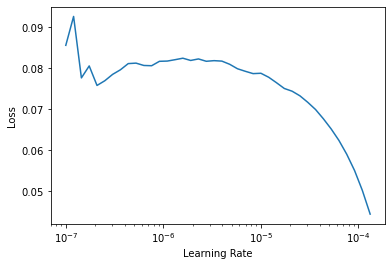

In [26]:
learn.lr_find()

In [27]:
lr = 1e-3
lrs = slice(lr/40,lr/4)
learn.fit_one_cycle(20, lrs)#, wd=1e-2, pct_start=0.2)

epoch,train_loss,valid_loss,time
0,0.026519,-0.004185,00:04
1,-0.133330,-0.298423,00:03
2,-0.355716,-0.654789,00:03
3,-0.512203,-0.722126,00:03
4,-0.609831,-0.750211,00:03
5,-0.672536,-0.767874,00:04
6,-0.713358,-0.776783,00:03
7,-0.741023,-0.786936,00:04
8,-0.762270,-0.796641,00:03
9,-0.778796,-0.804358,00:03


KeyboardInterrupt: 